In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

We will use mixure of Gaussians from sklearn

In [2]:
from sklearn.mixture import GaussianMixture

We will develop code for PCA (myPCA in HW3, Q4) ourselves, using numpy and scipy  
More instructions below on where myPCA will be used  
Also see HW3 Q4 for guidelines

Created my own implementation of PCA instead of the one from scikit.learn. The rest of the NoteBook uses myPCA. Due to differences in input and output arguments, I slightly changed the code in various areas. My PCA implementation seems to produce the output similar to the scikit.learn implementation.

In [3]:
# takes data and percentage as an inpute
# Note that unlike in scikit.learn's PCA, where percentage displayed as a value between 0 and 1, we display it between 0 and 100
def myPCA(X, alpha): 
    features = X.T 
    mean_vec = np.mean(X, axis = 0)
    cov_matrix = np.cov(features) 
    eig_values, eig_vectors = np.linalg.eig(cov_matrix) 
    # create an array of tuples with eigenvalues and eigenvectors
    eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:,i]) for i in range(len(eig_values))]
    # sort the array, so the tuples with biggest eigenvalues would be at the beginning
    eig_pairs.sort(key=lambda tup: tup[0]) 
    eig_pairs.reverse() 
    # compute the necessary number of dimensions to preserve alpha% accuracy
    percentage = 0
    dimensionality = 0
    for i in eig_pairs:
        if percentage < alpha:
            eigval_weight = i[0] / np.sum(eig_values)
            percentage = percentage + eigval_weight * 100
            dimensionality = dimensionality + 1
        else:
            break
            
    # create a projection matrix W using the eigenvectors 
    matrix_w = np.array([np.hstack(eig_pairs[i][1].reshape(64,1)) for i in range(dimensionality)])
    # use projection matrix to reduce the data dimensionality
    dimen_matrix = np.array((X - mean_vec).dot(matrix_w.T))

    # return a tuple of reduced data, projection matrix and mean vector 
    # int d is not returned, because we can get it by taking length of W (besides, we don't use d itself for anything)
    return dimen_matrix, matrix_w, mean_vec

Loading the digits dataset

In [4]:
from sklearn.datasets import load_digits
digits = load_digits()

Plotting the first 100 digits in a 10 x 10 grid  
This is just to remind ourselves what the data looks like

In [5]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)

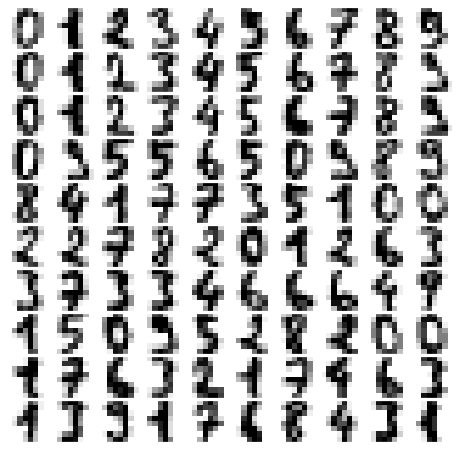

In [6]:
plot_digits(digits.data)

We are using sklearn's PCA here, these will be replaced by your code for myPCA (HW3, Q4)  
We are creating a low-dimensional projection so that 90% of the variance is preserved after projection  
The exact dimensionality needed can be determined using the eigen-values of the covariance matrix of the data  
For preserving 90% of the variance, we need 21 dimensions, original data had 64 dimensions! 

In [7]:
# capture three values returned by myPCA
data90, pca90_W, pca90_mean = myPCA(digits.data, 90)
print(f"Data shape: {data90.shape} \nProjection matrix shape: {pca90_W.shape} \nMean vector shape: {pca90_mean.shape}")

Data shape: (1797, 21) 
Projection matrix shape: (21, 64) 
Mean vector shape: (64,)


Next we fit a mixture of Gaussians on the projected data  
The first step is to figure how many components to use  
We use a model selection criterion called AIC, we have not discussed this in class  
Just use this bit as is

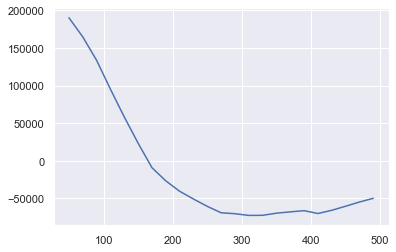

In [8]:
n_components = np.arange(50, 510, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data90).aic(data90) for model in models]
plt.plot(n_components, aics);

Looks like 310 components would suffice  
So we will fit a mixture of 310 Gaussians to the projected data  
Note that we are doing the fit in a 21 dimensional space

In [9]:
gmm90 = GaussianMixture(310, covariance_type='full', random_state=0)
gmm90.fit(data90)
print(gmm90.converged_)

True


Now, we will sample 100 samples from the learned mixture of 310 Gaussians  
Each sample will be a point in the 21 dimensional (projected) space  

In [10]:
data_new90 = gmm90.sample(100)[0]
data_new90.shape

(100, 21)

Finally, we will transform these 100 points in 21 dimensions back to the original 64 dimensional space  
We can then visualize them, and see if they look like digits from the digits dataset   
Note that these new digits were *not* part of the original digits dataset    
We learned a model for 8x8 handwritten digits and now we can generate data (handwritten digits) from that model

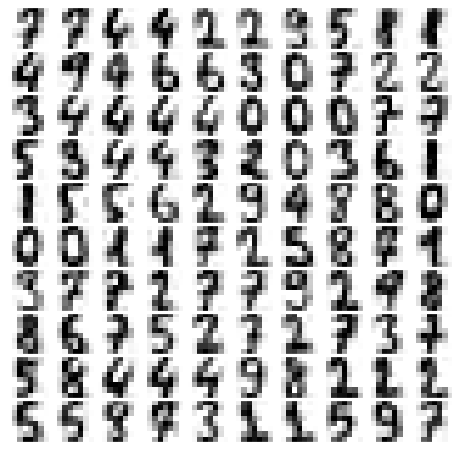

In [11]:
# reversing the newly generated digits to the original dimension
digits_new90 = np.dot(data_new90, pca90_W) + pca90_mean
plot_digits(digits_new90)

We will repeat the same exercise but by preserving 99% of the variance in the projected space  
We will need 41 (instead of 21) dimensions to preserve 99% (instead of 90%) of the variance  

In [12]:
# capture three values returned by myPCA
data99, pca99_W, pca99_mean = myPCA(digits.data, 99)
print(f"Data shape: {data99.shape} \nProjection matrix shape: {pca99_W.shape} \nMean vector shape: {pca99_mean.shape}")

Data shape: (1797, 41) 
Projection matrix shape: (41, 64) 
Mean vector shape: (64,)


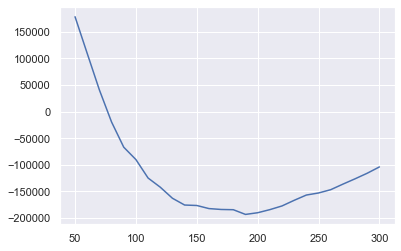

In [13]:
n_components = np.arange(50, 310, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data99).aic(data99) for model in models]
plt.plot(n_components, aics);

In [14]:
gmm99 = GaussianMixture(140, covariance_type='full', random_state=0)
gmm99.fit(data99)
print(gmm99.converged_)

True


In [15]:
data_new99 = gmm99.sample(100)[0]
data_new99.shape

(100, 41)

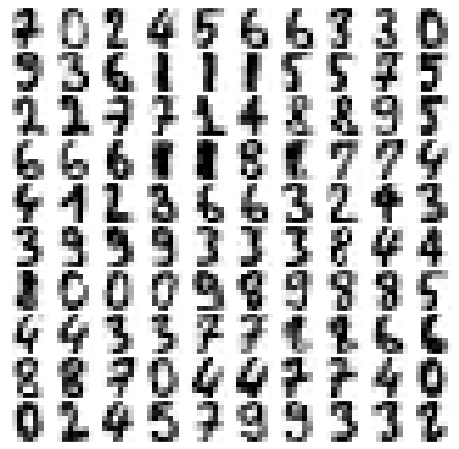

In [16]:
# reversing the newly generated digits to the original dimension
digits_new99 = np.dot(data_new99, pca99_W) + pca99_mean
plot_digits(digits_new99)